In [55]:
import random
from joblib import  load
import numpy as np
import numpy.ma as ma  

import pandas as pd

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

import random
from collections import defaultdict
from typing import Tuple, Dict, List
import torch
# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
from torch import optim, nn, utils, transpose, device, cuda, save, isinf, backends, manual_seed, LongTensor, tensor, long
DEVICE = device(f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu')
from typing import Optional, Literal, List, Tuple, Union
from torch.optim import Adam
from pathlib import Path
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE
import torch
import os
from torch import optim, nn, logsumexp, cuda, save, backends, manual_seed, LongTensor, zeros_like, ones_like, tensor, cat
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader, random_split
torch.autograd.set_detect_anomaly(True)
from model.model import EncoderRNN, DecoderRNN
import numpy as np
from torch.optim import Adam
import itertools
import random
from pathlib import Path
from tqdm import tqdm
import data.dataset as dataset_lib
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE
import ar_vae_metrics as m
import monitoring as mn
import regularization as r
sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 6, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [2]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [3]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())

def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)

def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())


In [4]:
def select_peptides(results, mode):
    if mode=='pos':
        peptides = np.array(results[f'pos_peptides']).reshape(64, -1).T
        amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
        mic = results['pos_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmax(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )
    else:
        peptides = np.array(results['neg_peptides']).reshape(64, -1).T
        amp = (results['neg_class_prediction'] > 0.2).reshape(64, -1)
        mic = results['neg_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmin(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['neg_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['neg_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )

# Unconstrained

In [51]:
sequences_arvae = pd.read_csv('./sequences.csv', header=None)
sequences_arvae[0] = sequences_arvae[0].str.strip().str.rstrip("0")
df_arvae = sequences_arvae[~sequences_arvae[0].str.contains("0")]
generated_arvae = df_arvae[0].tolist()

sequences_iwae = pd.read_csv('./sequences_iwae.csv', header=None)
sequences_iwae[0] = sequences_iwae[0].str.strip().str.rstrip("0")
df_iwae = sequences_iwae[~sequences_iwae[0].str.contains("0")]
generated_iwae = df_iwae[0].tolist()

uniprot_df = pd.read_csv('./data/Uniprot_0_25_train.csv')
uniprot_peptides = uniprot_df['Sequence'].tolist()

In [6]:
#Get random peptides
random_gen = modlamp.sequences.Random(50000, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


In [34]:
class AMPDataManager:

    def __init__(
            self,
            positive_filepath: str,
            negative_filepath: str,
            min_len: int,
            max_len: int,
    ):
        self.positive_data = pd.read_csv(positive_filepath)
        self.negative_data = pd.read_csv(negative_filepath)

        self.min_len = min_len
        self.max_len = max_len

    def _filter_by_length(self, df: pd.DataFrame) -> pd.DataFrame:
        mask = (df['Sequence'].str.len() >= self.min_len) & (df['Sequence'].str.len() <= self.max_len)
        return df.loc[mask]

    def _filter_data(self):
        return self._filter_by_length(self.positive_data), self.negative_data

    @staticmethod
    def _get_probs(peptide_lengths: List[int]) -> Dict[int, float]:
        probs = defaultdict(lambda: 1)
        for length in peptide_lengths:
            probs[length] += 1
        return {k: round(v / len(peptide_lengths), 4) for k, v in probs.items()}

    @staticmethod
    def _draw_subsequences(df, new_lengths):
        # random.seed(44)
        new_lengths.sort(reverse=True)
        df = df.sort_values(by="Sequence length", ascending=False)

        d = []
        for row, new_length in zip(df.itertuples(), new_lengths):
            seq = row[2]
            curr_length = row[3]
            if new_length > curr_length:
                new_seq = seq
            elif new_length == curr_length:
                new_seq = seq
            else:
                begin = random.randrange(0, int(curr_length) - new_length)
                new_seq = seq[begin:begin + new_length]
            d.append(
                {
                    'Name': row[1],
                    'Sequence': new_seq,
                }
            )
        new_df = pd.DataFrame(d)
        return new_df

    def _equalize_data(self, positive_data: pd.DataFrame, negative_data: pd.DataFrame, balanced_classes: bool = True):
        positive_seq = positive_data['Sequence'].tolist()
        positive_lengths = [len(seq) for seq in positive_seq]

        negative_seq = negative_data['Sequence'].tolist()
        negative_lengths = [len(seq) for seq in negative_seq]
        negative_data.loc[:, "Sequence length"] = negative_lengths

        probs = self._get_probs(positive_lengths)
        k = len(positive_lengths) if balanced_classes else len(negative_lengths)

        new_negative_lengths = random.choices(list(probs.keys()), probs.values(), k=k)
        negative_data_distributed = self._draw_subsequences(self.negative_data, new_negative_lengths)
        return positive_data, negative_data_distributed

    def plot_distributions(self, equalize: bool = True):
        if equalize:
            pos_dataset, neg_dataset = self.get_data()
        else:
            pos_dataset, neg_dataset = self.positive_data, self.negative_data
        sns.set(color_codes=True)
        # TODO: figure out where this functionality should be. Goal is to plot distribution before and after baladancing
        positive_seq = pos_dataset['Sequence'].tolist()
        positive_lengths = [len(seq) for seq in positive_seq]

        negative_seq = neg_dataset['Sequence'].tolist()
        negative_lengths = [len(seq) for seq in negative_seq]

        fig, (ax2, ax3) = plt.subplots(figsize=(12, 6), ncols=2)
        sns.distplot(positive_lengths, ax=ax2)
        sns.distplot(negative_lengths, ax=ax3)
        ax2.set_title("Positive")
        ax3.set_title("Negative")

        plt.show()

    def _join_datasets(self, pos_dataset: pd.DataFrame, neg_dataset: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        pos_dataset.loc[:, 'Label'] = 1
        neg_dataset.loc[:, 'Label'] = 0
        merged = pd.concat([pos_dataset, neg_dataset])
        x = np.asarray(merged['Sequence'].tolist())
        y = np.asarray(merged['Label'].tolist())
        return x, y

    def get_data(self, balanced: bool = True):
        pos_dataset, neg_dataset = self._filter_data()
        return self._equalize_data(pos_dataset, neg_dataset, balanced_classes=balanced)

    def get_merged_data(self, balanced: bool = True):
        pos_dataset, neg_dataset = self.get_data(balanced=balanced)
        return self._join_datasets(pos_dataset, neg_dataset)

In [35]:
def set_seed(seed: int = 42) -> None:
    """
    Source:
    https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
    """
    np.random.seed(seed)
    random.seed(seed)
    manual_seed(seed)
    cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    backends.cudnn.deterministic = True
    backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    # logger.info(f"Random seed set to {seed}")
    return None
set_seed()

data_manager = AMPDataManager(
    './data/unlabelled_positive.csv',
    './data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
baseline_peptides = amp_x.tolist()
df = pd.DataFrame({
    'Sequence': amp_x,
    'Label': amp_y
})
nonamp_peptides = df[df['Label'] == 0]['Sequence'].to_list()
amp_peptides = df[df['Label'] == 1]['Sequence'].to_list()

C:\Users\olagw\AppData\Local\Temp\ipykernel_23408\3809696541.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_dataset.loc[:, 'Label'] = 1


In [36]:
def calculate_physchem(peptides, datasets):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []


    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [37]:
datasets = [
    'Uniprot',
    'AMPs',
    'Non AMPs'
]

peptides = [
    uniprot_peptides,
    amp_peptides,
    nonamp_peptides
]

In [38]:
physchem = calculate_physchem(peptides, datasets)

In [ ]:
sequences_arvae_right = pd.read_csv('./sequences.csv', header=None)
sequences_arvae_right[0] = sequences_arvae_right[0].str.strip().str.rstrip("0")
df_arvae_right = sequences_arvae_right[~sequences_arvae_right[0].str.contains("0")]
generated_arvae_right = df_arvae_right[0].tolist()

sequences_arvae_left = pd.read_csv('./sequences.csv', header=None)
sequences_arvae_left[0] = sequences_arvae_left[0].str.strip().str.rstrip("0")
df_arvae_left = sequences_arvae_left[~sequences_arvae_left[0].str.contains("0")]
generated_arvae_left = df_arvae_left[0].tolist()

peptides_arvae_lr = calculate_physchem([generated_arvae_left, generated_arvae_right], [['AR-VAE generated z from left', 'AR-VAE generated z from right']])

In [89]:
peptides_arvae_lr

,dataset,length,charge,pi,aromacity,hydrophobicity,hm
0,"[AR-VAE generated z from left, AR-VAE generate...",17,4.094,11.572266,0.000000,0.254118,0.154917
1,"[AR-VAE generated z from left, AR-VAE generate...",13,2.655,7.942871,0.307692,0.047692,0.197752
2,"[AR-VAE generated z from left, AR-VAE generate...",25,-0.003,3.732422,0.040000,0.210400,0.168007
3,"[AR-VAE generated z from left, AR-VAE generate...",13,3.995,11.572266,0.153846,0.096154,0.284554
4,"[AR-VAE generated z from left, AR-VAE generate...",13,0.861,5.000000,0.153846,0.733846,0.181666
5,"[AR-VAE generated z from left, AR-VAE generate...",25,3.997,11.155273,0.120000,-0.132800,0.436737
6,"[AR-VAE generated z from left, AR-VAE generate...",9,2.928,10.031250,0.000000,-0.205556,0.130367
7,"[AR-VAE generated z from left, AR-VAE generate...",13,1.996,10.742188,0.000000,0.583077,0.380817
8,"[AR-VAE generated z from left, AR-VAE generate...",21,0.928,5.125000,0.047619,1.184286,0.116489
9,"[AR-VAE generated z from left, AR-VAE generate...",15,8.996,12.881348,0.133333,-1.028667,0.442743


In [88]:
chosen_columns = ['charge', 'hm','length']

print(type(chosen_columns))
print(peptides_arvae_lr.columns)
print(type(peptides_arvae_lr))
print('dataset' in peptides_arvae_lr.columns)


choosen = peptides_arvae_lr[0]
mean_values_by_dataset = choosen.groupby('dataset')[chosen_columns].mean()

<class 'list'>
Index(['dataset', 'length', 'charge', 'pi', 'aromacity', 'hydrophobicity',
       'hm'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
True


KeyError: 0

In [60]:
custom = [['GWLNKIIKKAWRKFHEIFSK', 'GWLWKIIKKAWRKFHEIFWK', 'GWLKKIIKKAWRKFHKIFSK']]
calculate_physchem(custom, [['Custom']])

,dataset,length,charge,pi,aromacity,hydrophobicity,hm
0,[Custom],20,6.095,11.218750,0.2,-0.084,0.655211
1,[Custom],20,6.095,11.218750,0.3,0.045,0.629949
2,[Custom],20,9.093,11.903809,0.2,-0.158,0.686947


In [13]:
physchem_temp = physchem.loc[:, ['pi', 'charge', 'hm', 'aromacity', 'dataset']]
physchem_quantiles = physchem_temp.groupby('dataset').quantile([0.25, 0.5, 0.75])
physchem_quantiles.to_csv('Supp_SourceData_FigureS1_quantiles.csv')

## Boxplots

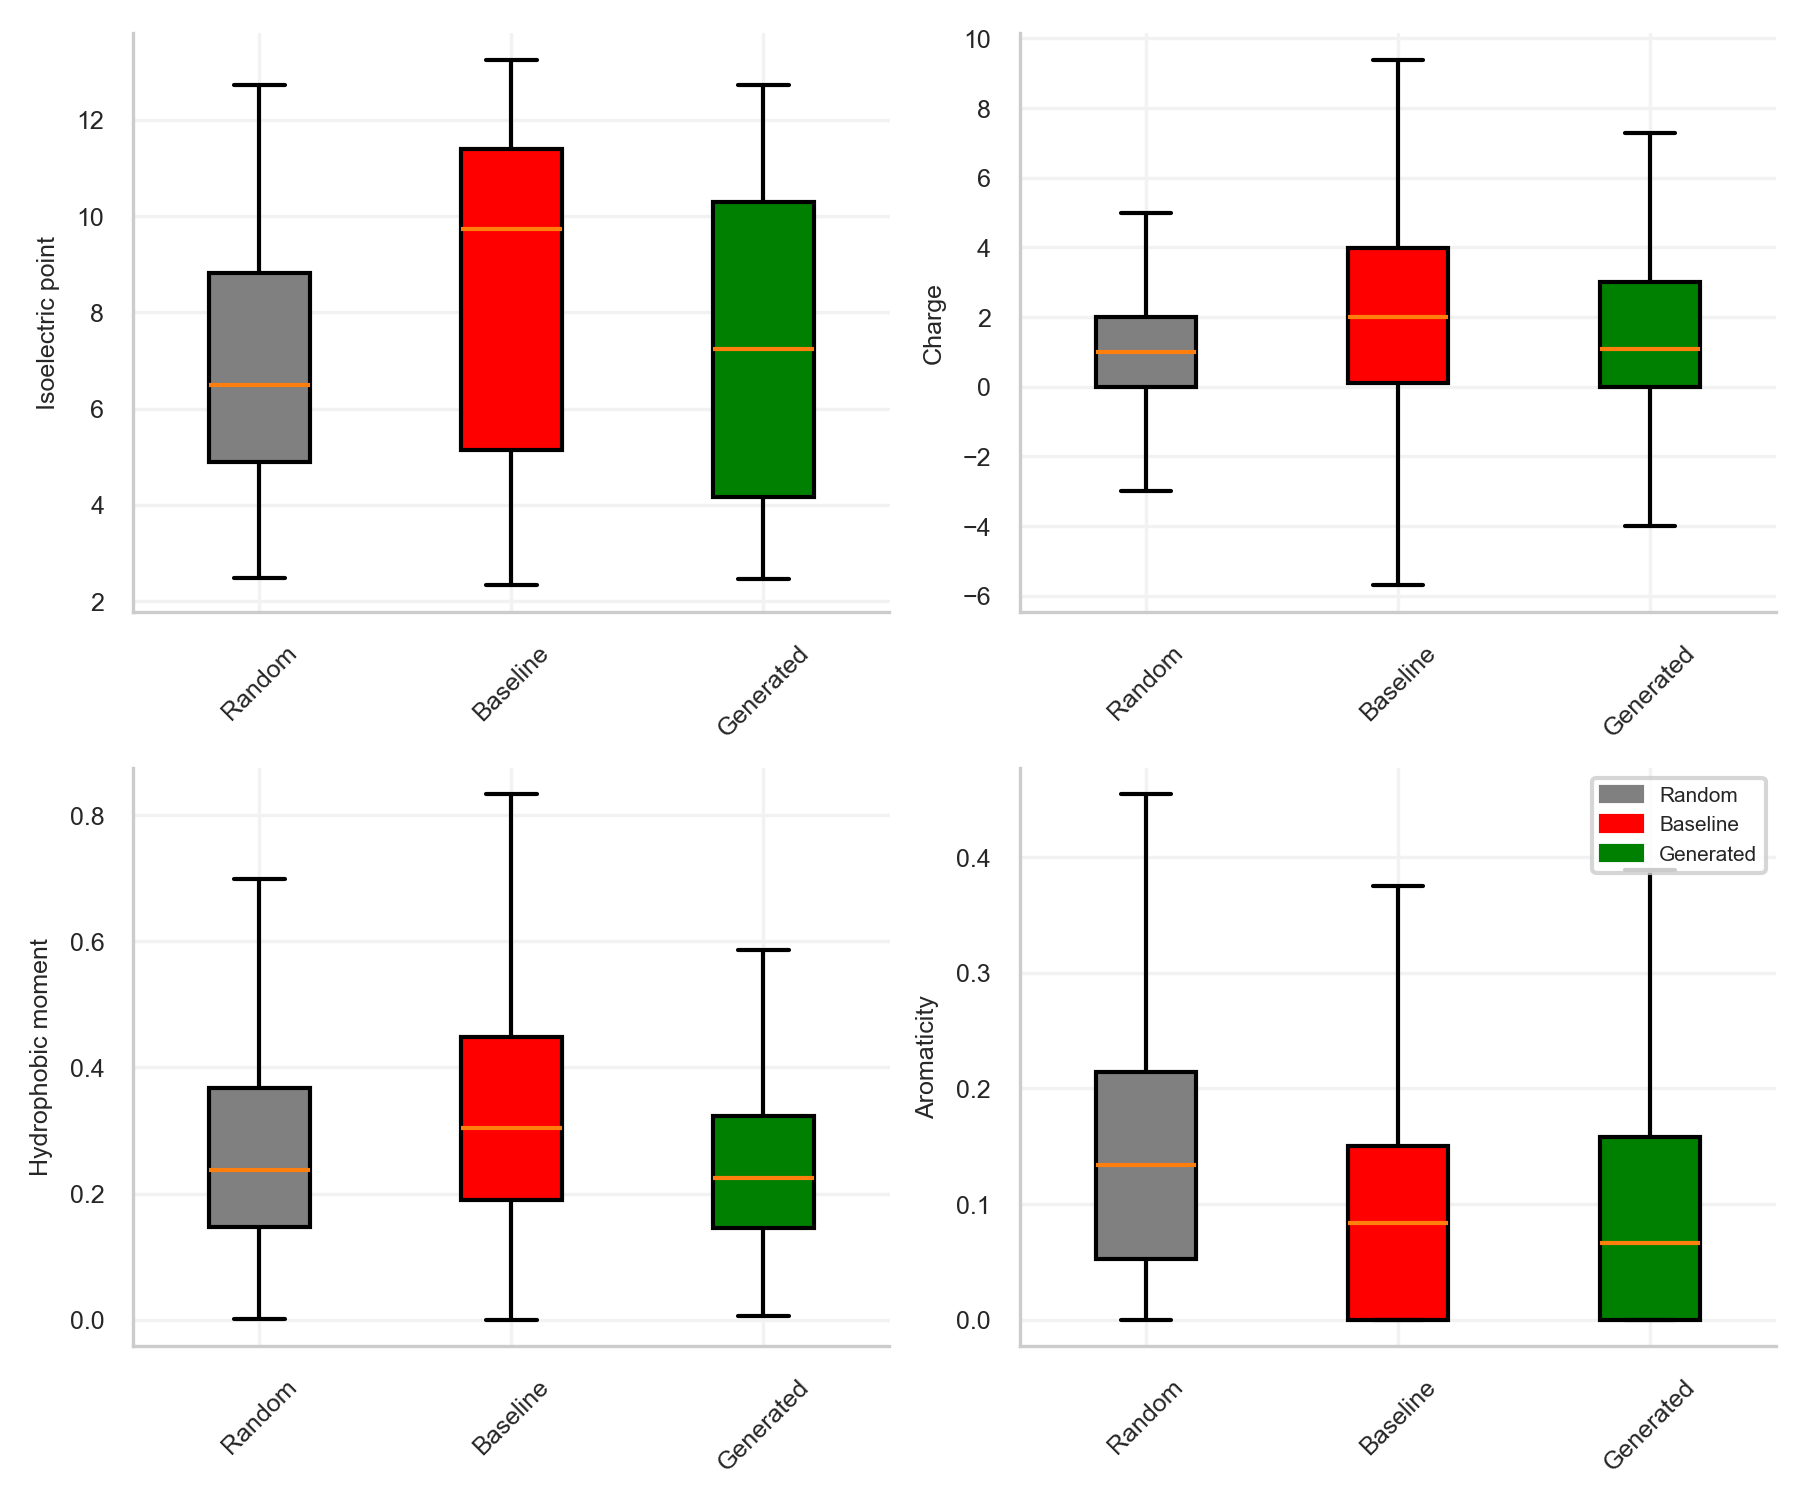

In [64]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Random', 'Baseline', 'Generated']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.boxplot(
        filtered_data,
        showfliers=False,
        patch_artist=True,
        widths=0.4
    )
    
    # Apply colors
    for patch, color in zip(parts['boxes'], ['grey', 'red', 'green']):
        patch.set_facecolor(color)
    
    # Set labels
    ax.set_xticks([1, 2, 3])  
    ax.set_xticklabels(['Random', 'Baseline', 'Generated'], rotation=45)
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    
        mpatches.Patch(color='red', label='Baseline'),
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

for prop, label, ax in zip(properties, labels, axes):
    # Extract only "Random" and "Generated" data
    sample_amps = physchem.loc[physchem['dataset'] == 'AMPs', prop]
    sample_nonamps = physchem.loc[physchem['dataset'] == 'Non AMPs', prop]

    # U Manna-Whitneya test
    # alternative='two-sided' testuje, czy rozkłady są różne (niezależnie czy A > B czy B > A)
    # Możesz użyć 'less' lub 'greater' jeśli masz konkretną hipotezę kierunkową
    statistic, p_value = mannwhitneyu(sample_amps, sample_nonamps, alternative='two-sided')
    alpha = 0.05
    print(f"\nAtrybut: {prop}")
    print(f"Statystyka U: {statistic:.4f}")
    print(f"Wartość p: {p_value:.4f}")

    if p_value < alpha:
        print(f"-> Wynik: Istotna statystycznie różnica (p < {alpha}). Atrybut '{prop}' jest istotnie rozróżnialny.")
    else:
        print(f"-> Wynik: Brak istotnej statystycznie różnicy (p >= {alpha}). Atrybut '{prop}' nie jest istotnie rozróżnialny.")



Atrybut: charge
Statystyka U: 101985186.0000
Wartość p: 0.0000
-> Wynik: Istotna statystycznie różnica (p < 0.05). Atrybut 'charge' jest istotnie rozróżnialny.

Atrybut: hm
Statystyka U: 81716040.5000
Wartość p: 0.0000
-> Wynik: Istotna statystycznie różnica (p < 0.05). Atrybut 'hm' jest istotnie rozróżnialny.

Atrybut: length
Statystyka U: 61506840.0000
Wartość p: 0.3533
-> Wynik: Brak istotnej statystycznie różnicy (p >= 0.05). Atrybut 'length' nie jest istotnie rozróżnialny.


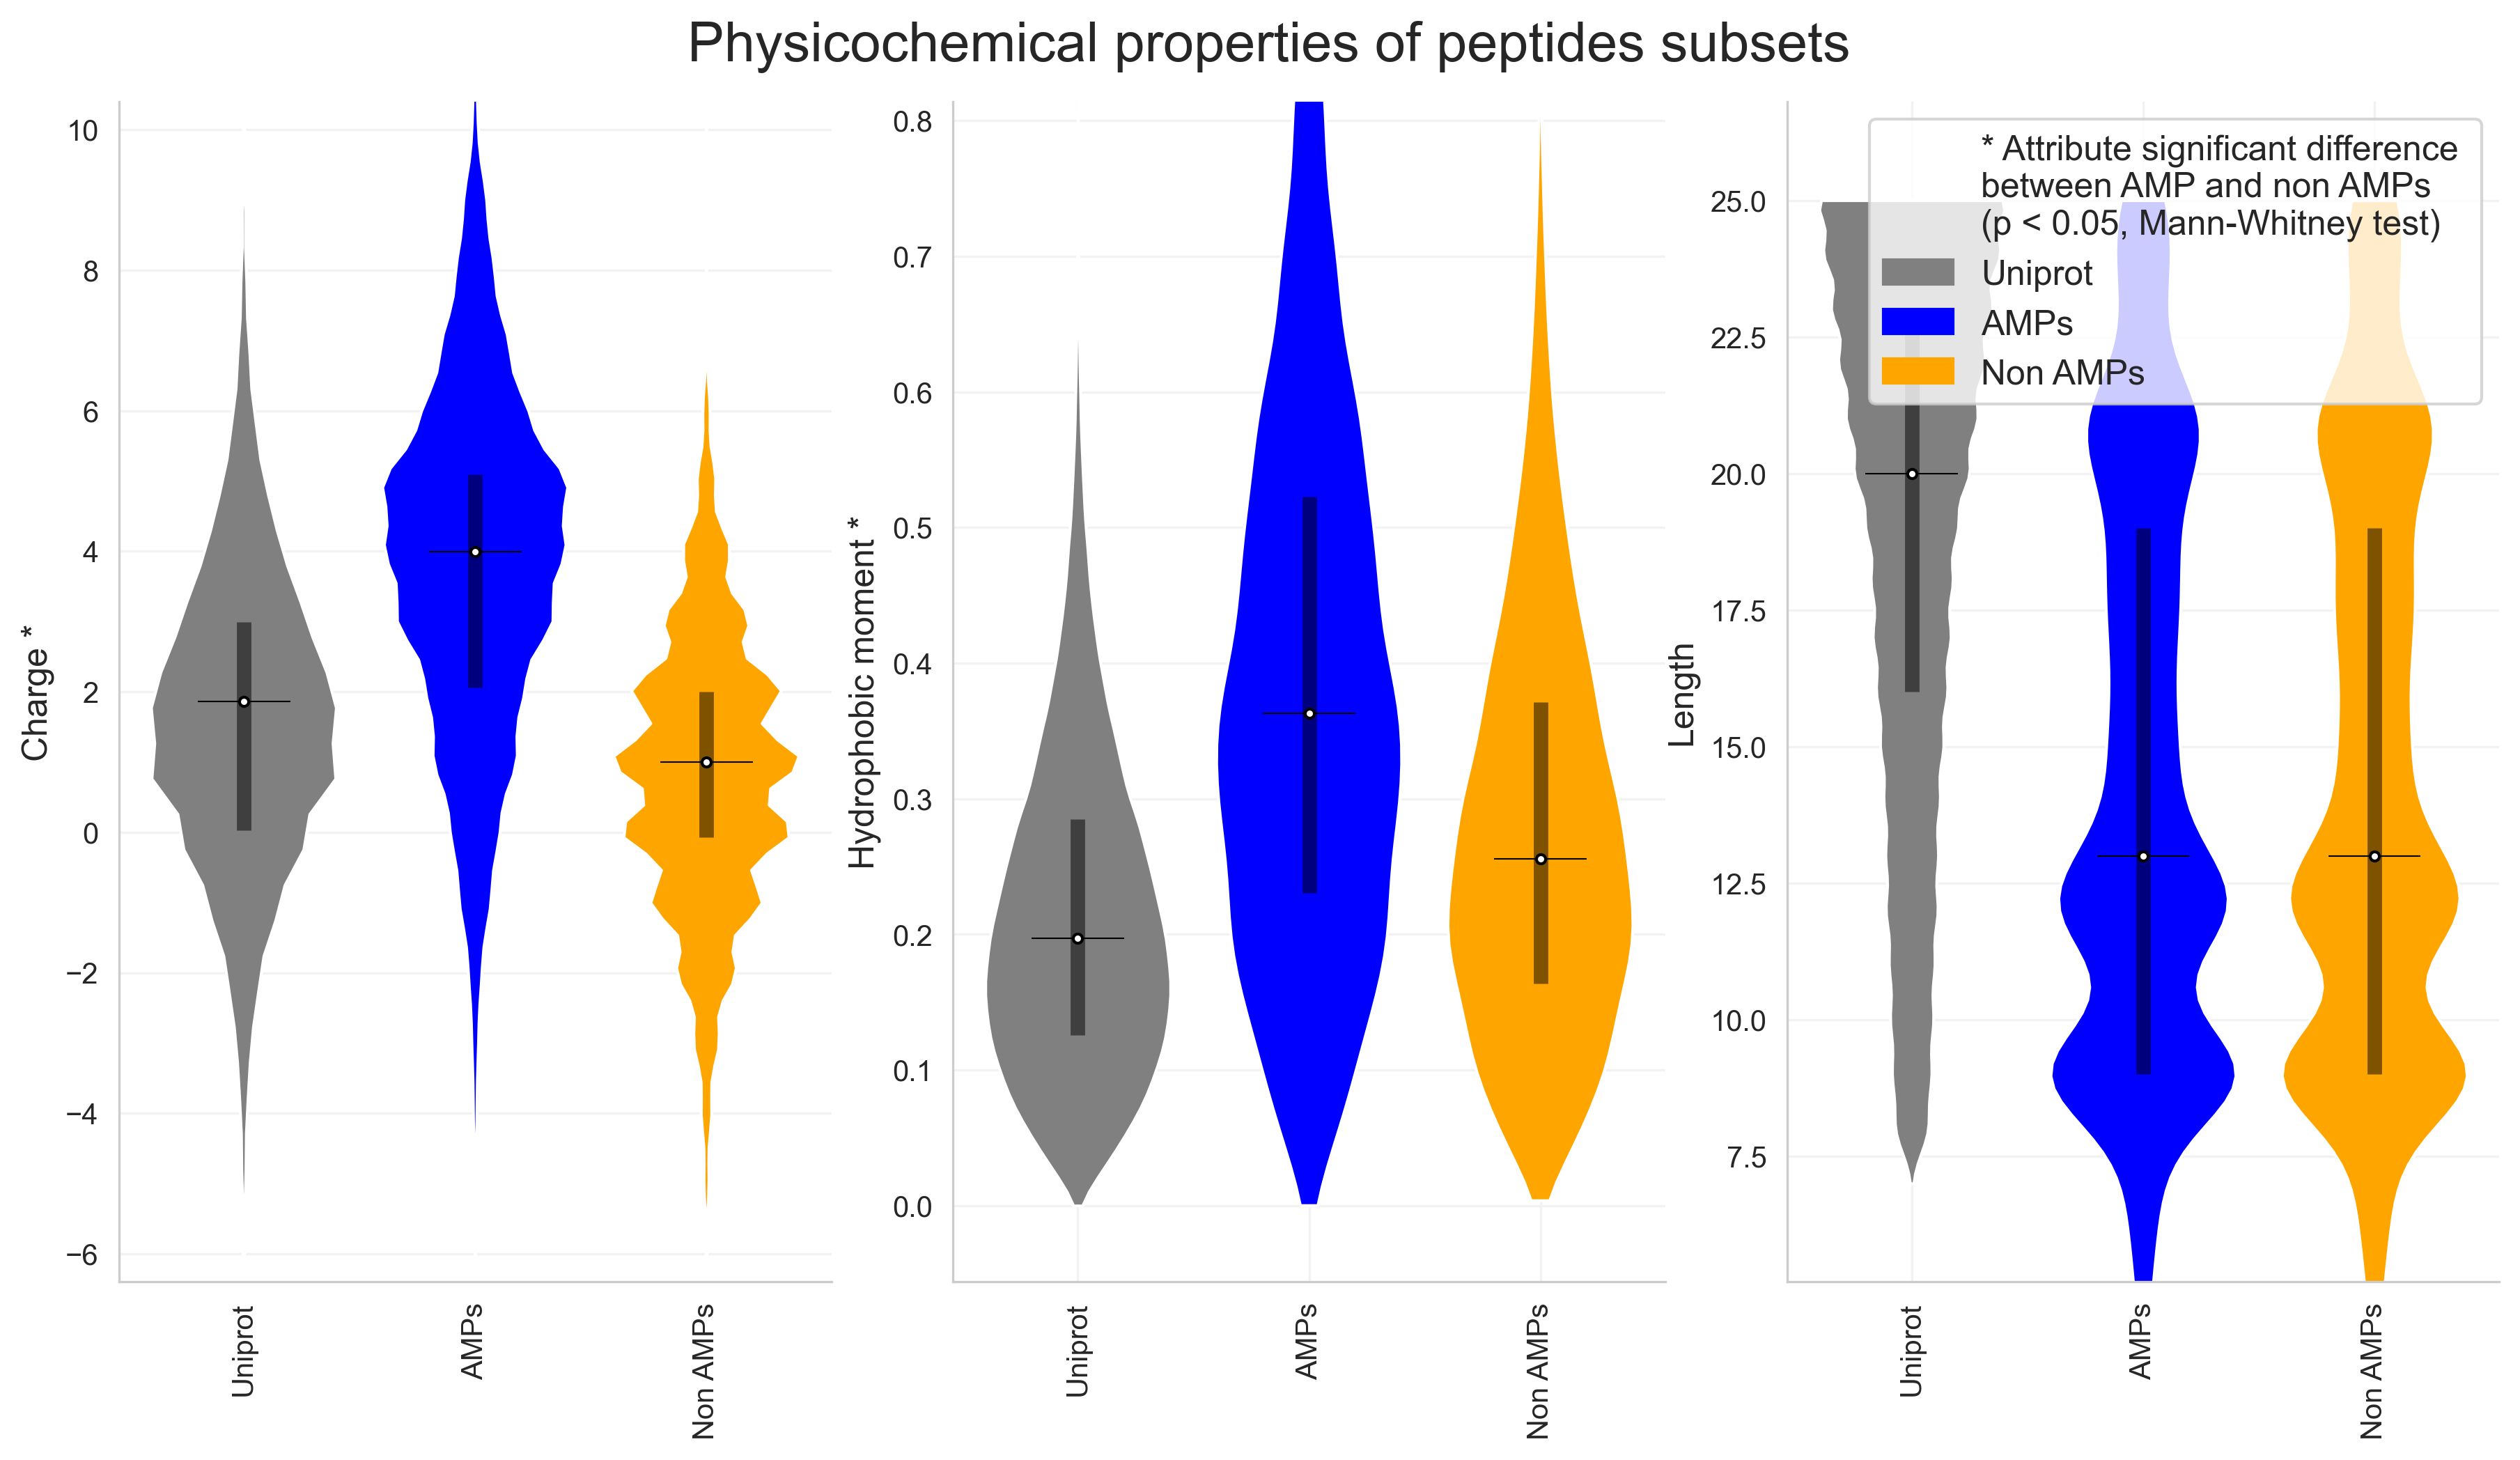

In [67]:

fig, _axes = plt.subplots(
    ncols=3, 
    nrows=1,
    figsize=(12, 6),
    dpi=300,
)
axes = [_axes[0], _axes[1], _axes[2]]
# Define properties and labels
properties = ['charge', 'hm', 'length']
labels = ['Charge', 'Hydrophobic moment', 'Length']

# Only use "Random" and "Generated"
selected_datasets = ['Uniprot', 'AMPs', 'Non AMPs']

for prop, label, ax in zip(properties, labels, axes):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    parts = ax.violinplot(
        filtered_data,
        showmeans=False,
        showmedians=True,
        showextrema=False,
        widths=0.8,
        bw_method='silverman',
        points=100,
    )

    # Apply colors
    for patch, color in zip(parts['bodies'], ['grey', 'blue', 'orange']):
        patch.set_facecolor(color)
        patch.set_alpha(1)

    # Customize median line if needed
    if 'cmedians' in parts:
        parts['cmedians'].set_color(medianprops.get('color', 'black'))
        parts['cmedians'].set_linewidth(medianprops.get('linewidth', 1.5))
        
    # Add Q1 and Q3 lines manually
    for i, dataset in enumerate(filtered_data):
        q1 = np.percentile(dataset, 25)
        q2 = np.percentile(dataset, 50)
        q3 = np.percentile(dataset, 75)
        
        # Box width
        box_width = 0.2
        x = i + 1

        # Box: vertical line (Q1 to Q3)
        ax.vlines(x, q1, q3, color='black', linewidth=5, alpha=0.5)

        # White dot at median
        ax.scatter(x, q2, facecolor='white', edgecolor='black', s=10, zorder=4)
        if label == 'Charge' or label == 'Hydrophobic moment':
            ax.set_ylabel(f"{label} *", fontsize = 12)
        else:
            ax.set_ylabel(f"{label}", fontsize = 12)
        # ax.set_xticklabels(selected_datasets)
        
    all_values = np.concatenate(filtered_data)
    ymin = np.quantile(all_values, 0.005)
    ymax = np.quantile(all_values, 0.995)
    yrange = ymax - ymin
    padding = yrange * 0.1 if yrange > 0 else 1
    ax.set_ylim(ymin - padding, ymax + padding)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='none', label='* Attribute significant difference \nbetween AMP and non AMPs \n(p < 0.05, Mann-Whitney test)'),
        mpatches.Patch(color='grey', label='Uniprot'),    
        mpatches.Patch(color='blue', label='AMPs'),
        mpatches.Patch(color='orange', label='Non AMPs'),
    ], 
    loc='upper right',
    fontsize = 12
)

for ax in [_axes[0], _axes[1], _axes[2]]:
    ax.set_xticks(range(1, len(selected_datasets) + 1))
    ax.xaxis.set_ticks_position('none') 
    ax.set_xticklabels(selected_datasets, rotation=90)
    ax.tick_params(axis='x', labelsize=10) # Zwiększ rozmiar czcionki znaczników osi X do 12
    ax.tick_params(axis='y', labelsize=10) # Zwiększ rozmiar czcionki znaczników osi Y do 12
plt.suptitle('Physicochemical properties of peptides subsets', fontsize = 19, y=1.05)
# Save & Show Plot
# fig.savefig("./Filtered_Random_Uniprot.svg")
# fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

## Distributions

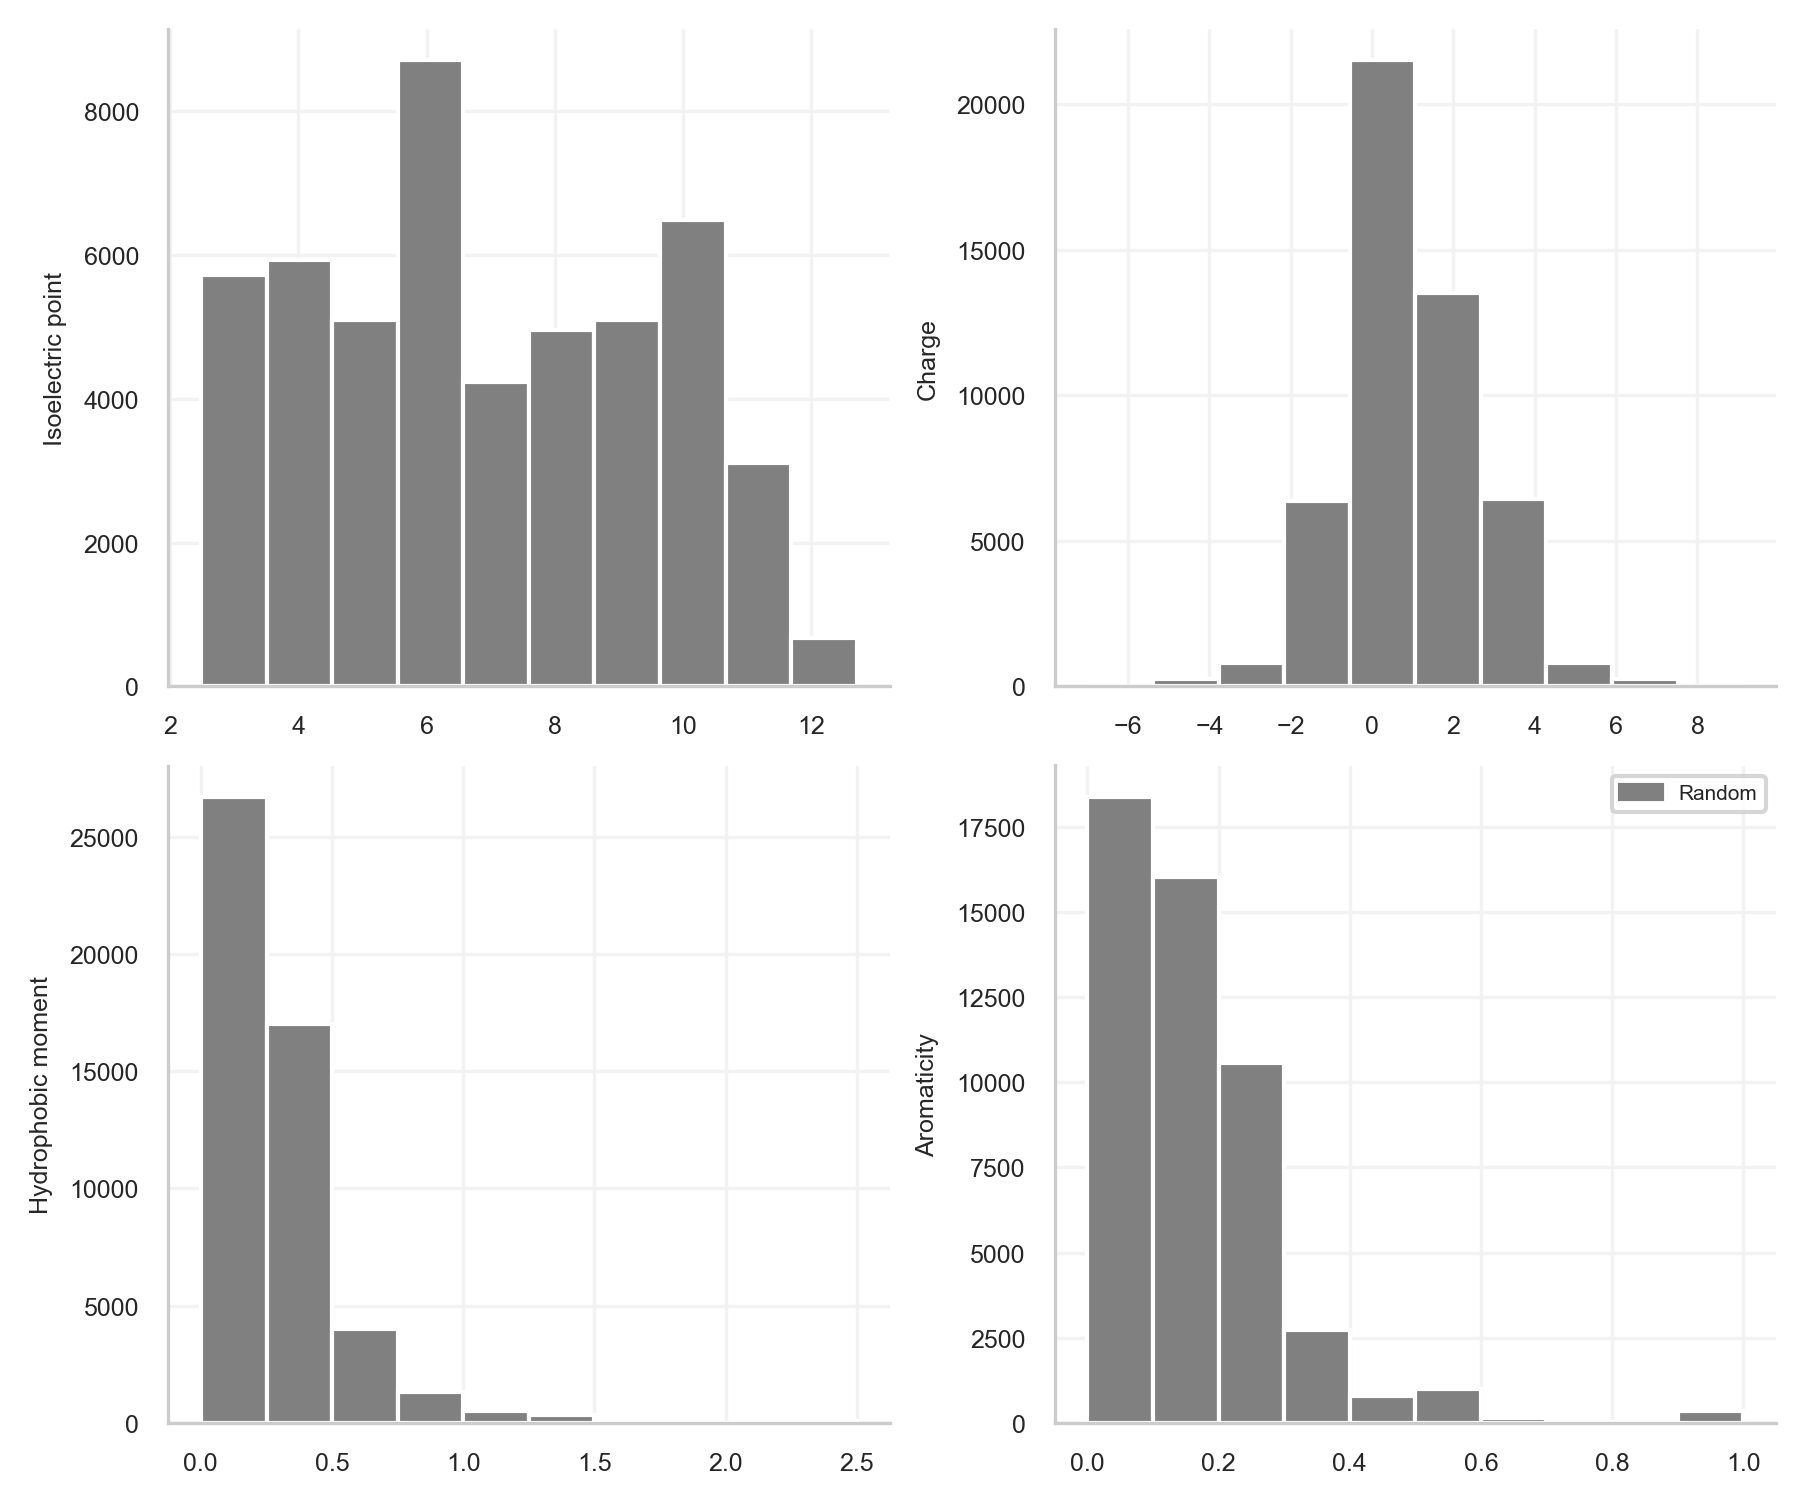

In [72]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Random']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['grey'], label=['Random']
    )
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    

    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

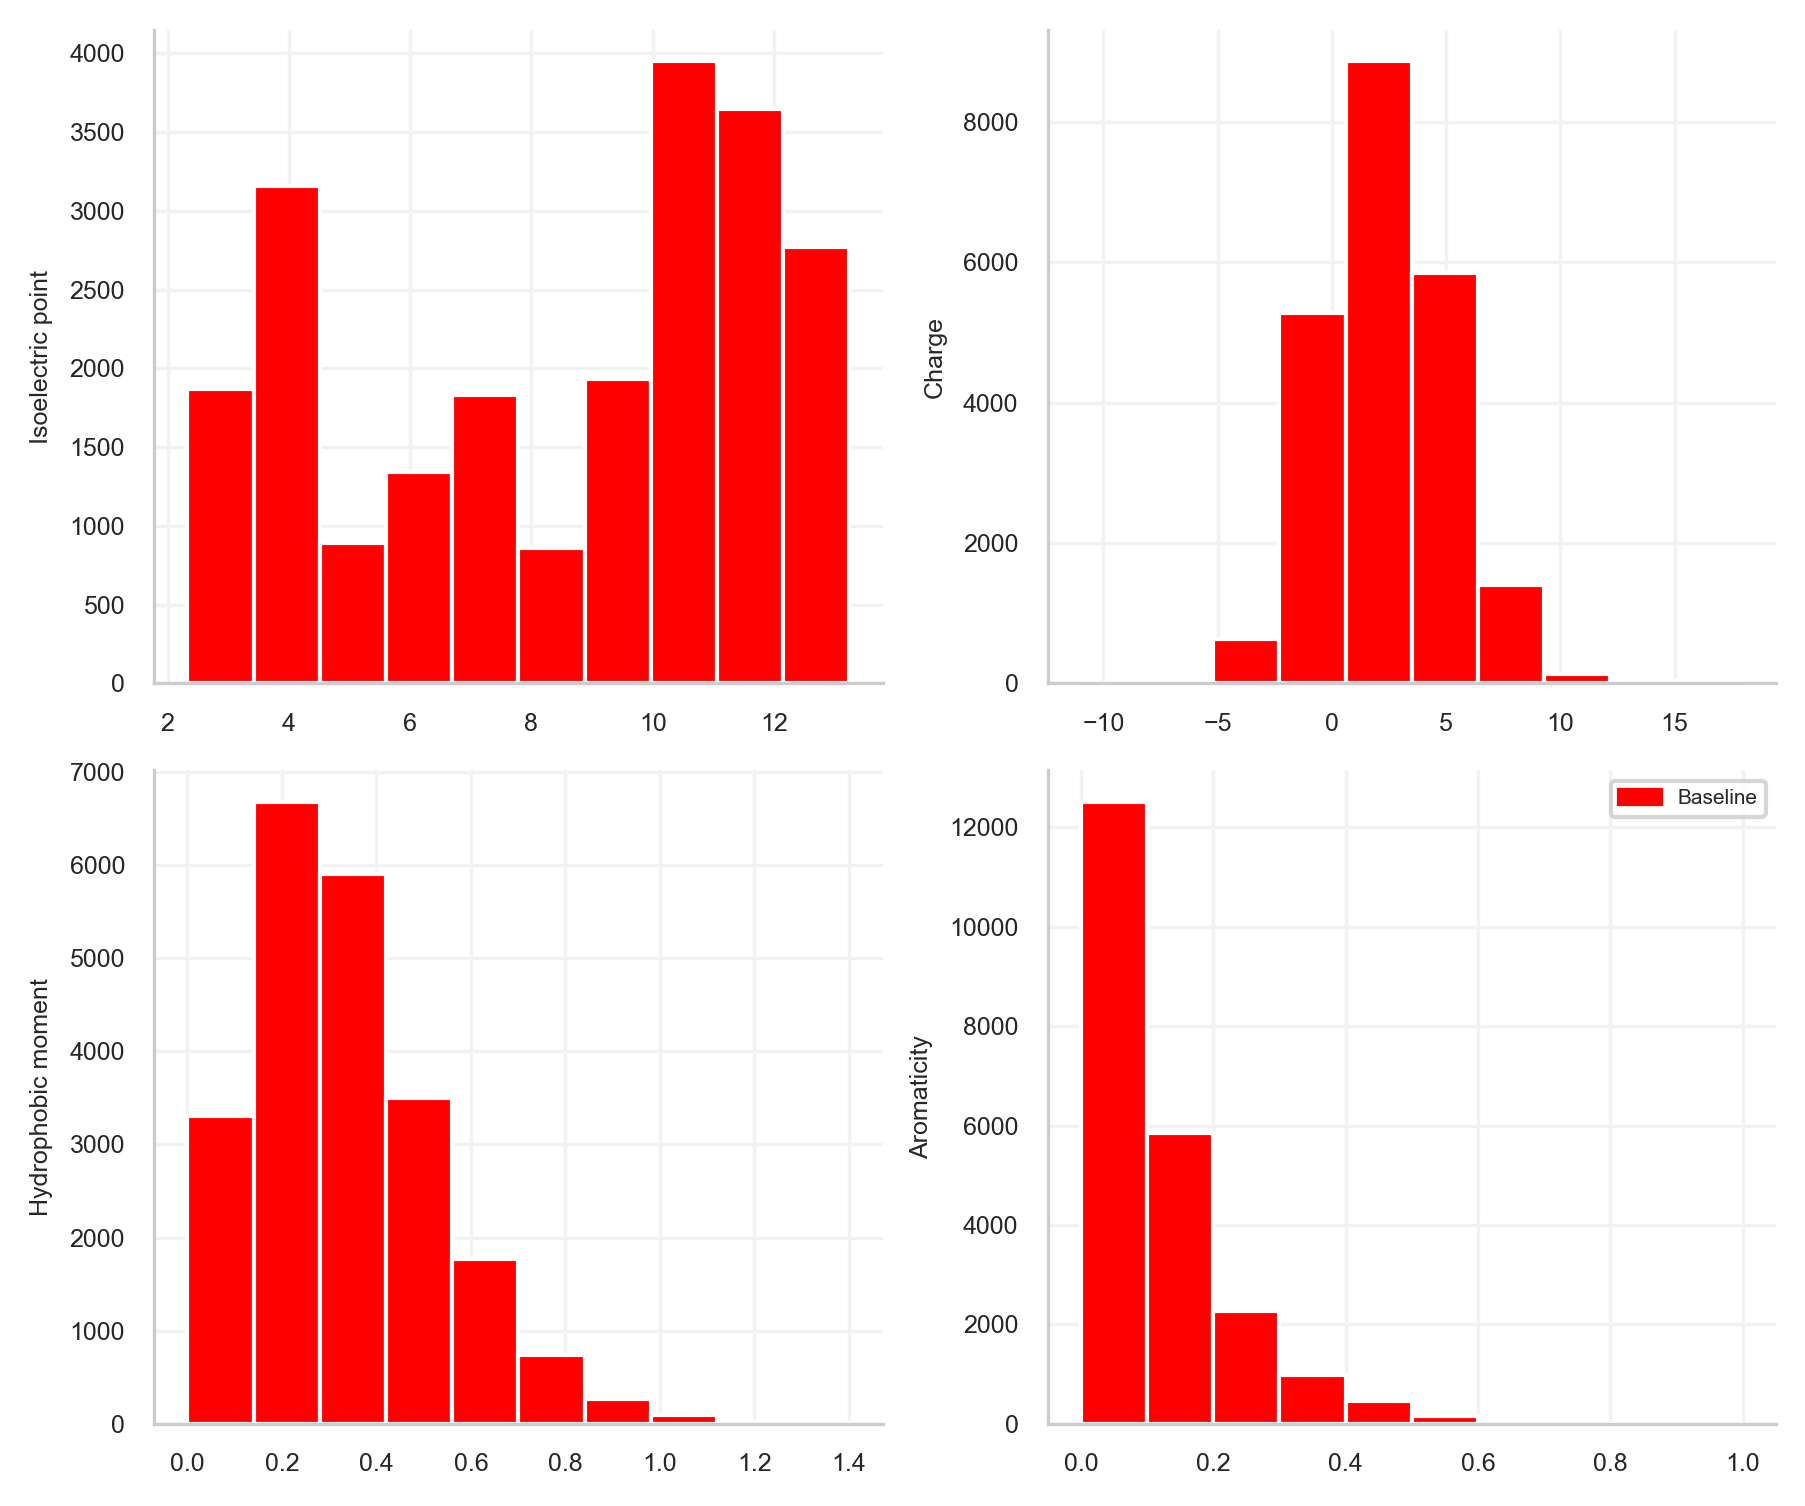

In [71]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Baseline']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['red'], label=['Baseline']
    )
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='red', label='Baseline'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

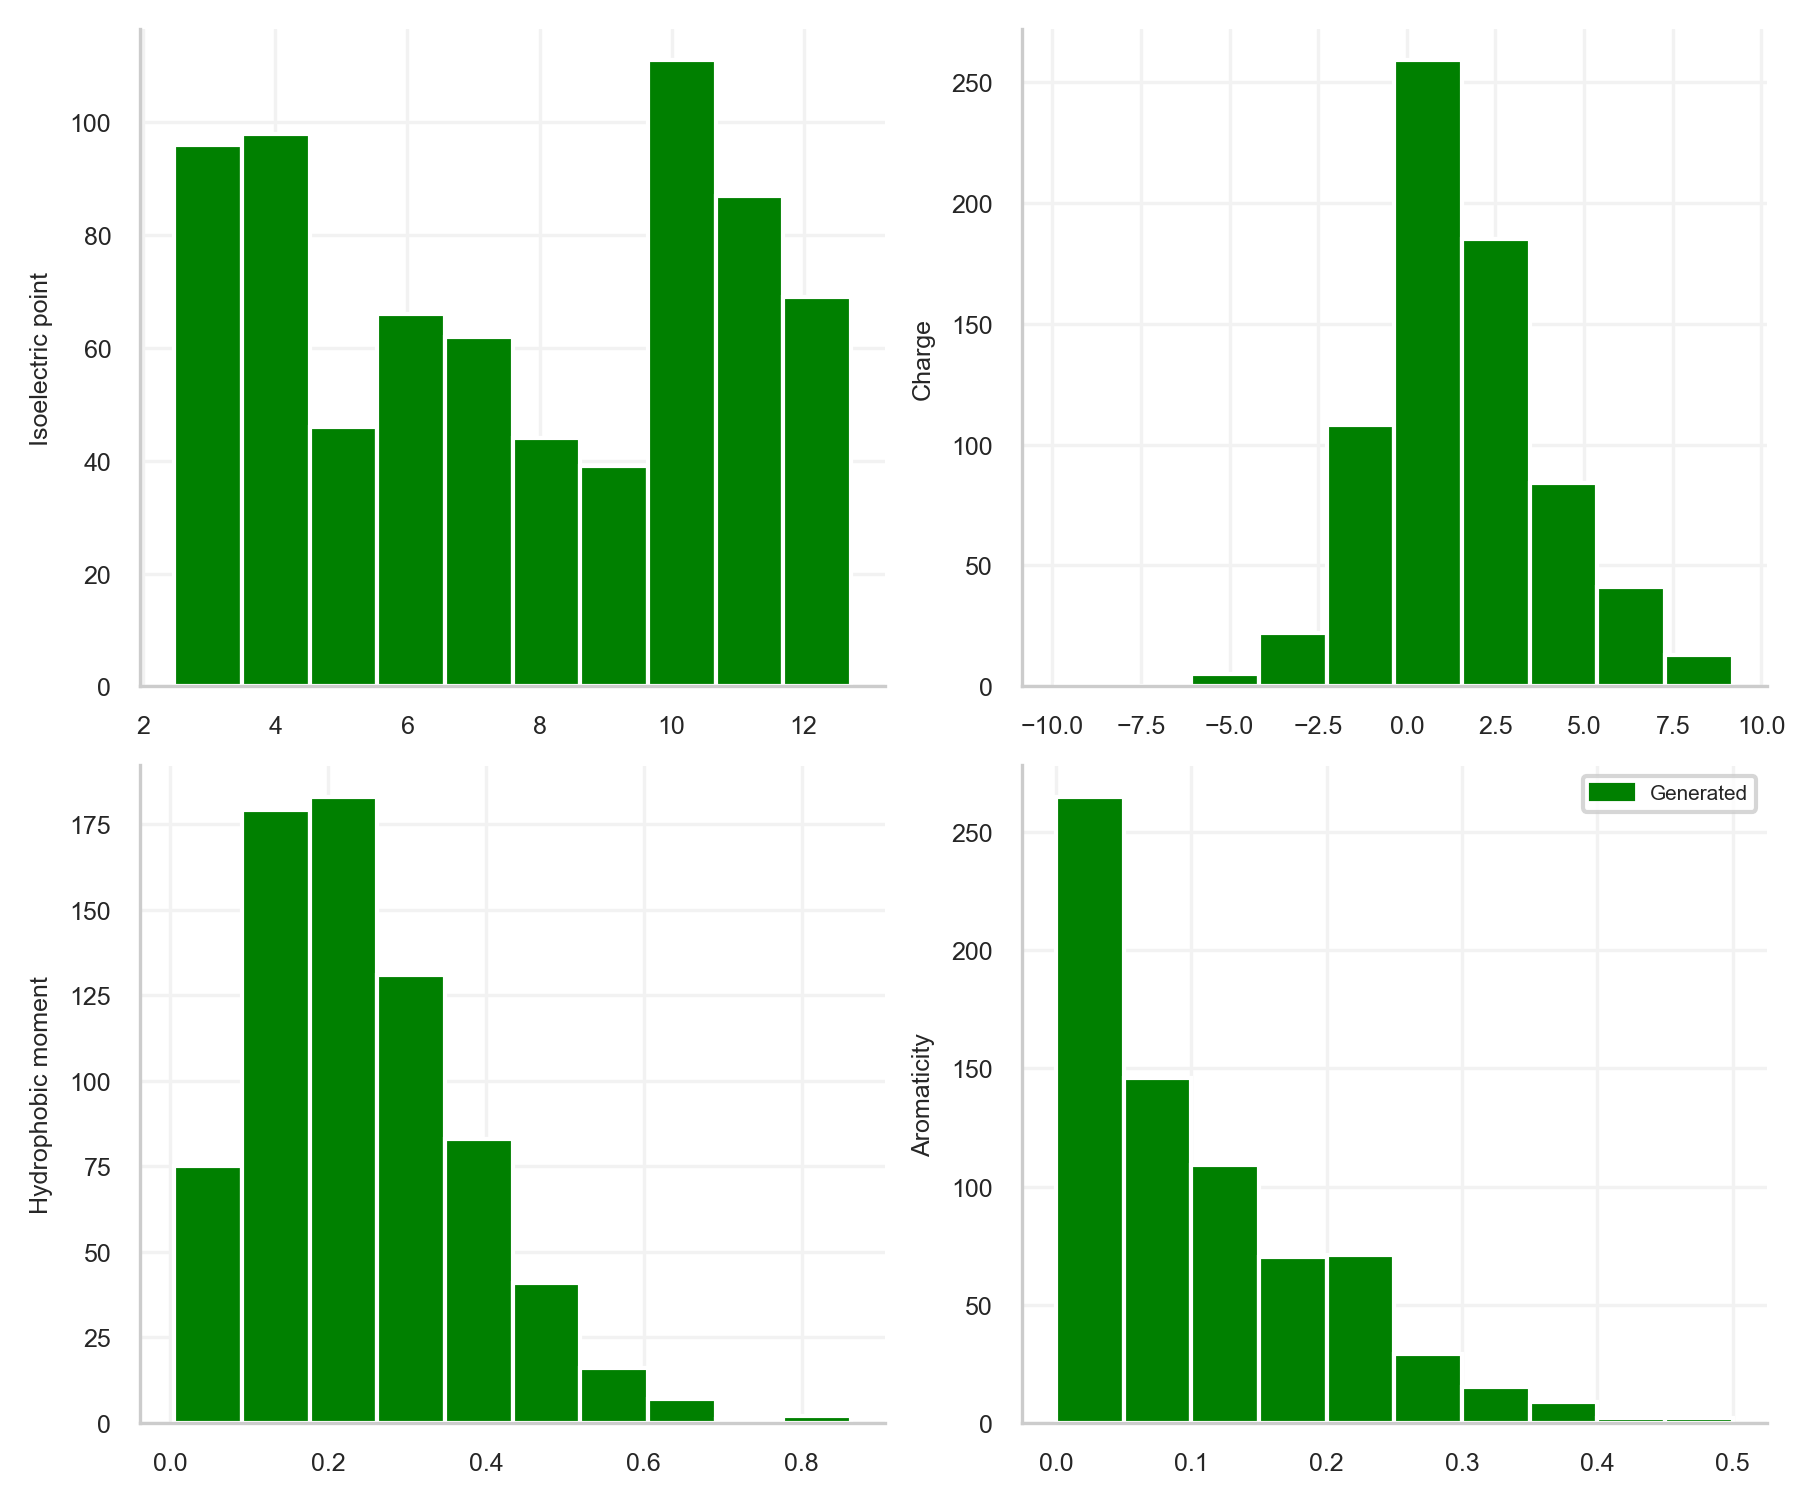

In [70]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Generated']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['green'], label=['Generated']
    )
    
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

## Histograms

In [52]:
from decimal import getcontext
STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
loop = [STD_AA[i:i+1][0] for i in range(0, len(STD_AA), 1)]
getcontext().prec = 3

freq_generated_arvae = {}
freq_baseline = {}
freq_generated_iwae = {}

# all_amino_uniprot = sum(len(s) for s in uniprot_peptides)
all_amino_baseline = sum(len(s) for s in baseline_peptides)
all_amino_generated_arvae = sum(len(s) for s in generated_arvae)
all_amino_generated_iwae = sum(len(s) for s in generated_iwae)
for amino in loop:
    freq_generated_arvae[amino] = sum(s.count(amino) for s in generated_arvae)/all_amino_generated_arvae
    freq_baseline[amino] = sum(s.count(amino) for s in baseline_peptides)/all_amino_baseline
    freq_generated_iwae[amino] = sum(s.count(amino) for s in generated_iwae)/all_amino_generated_iwae

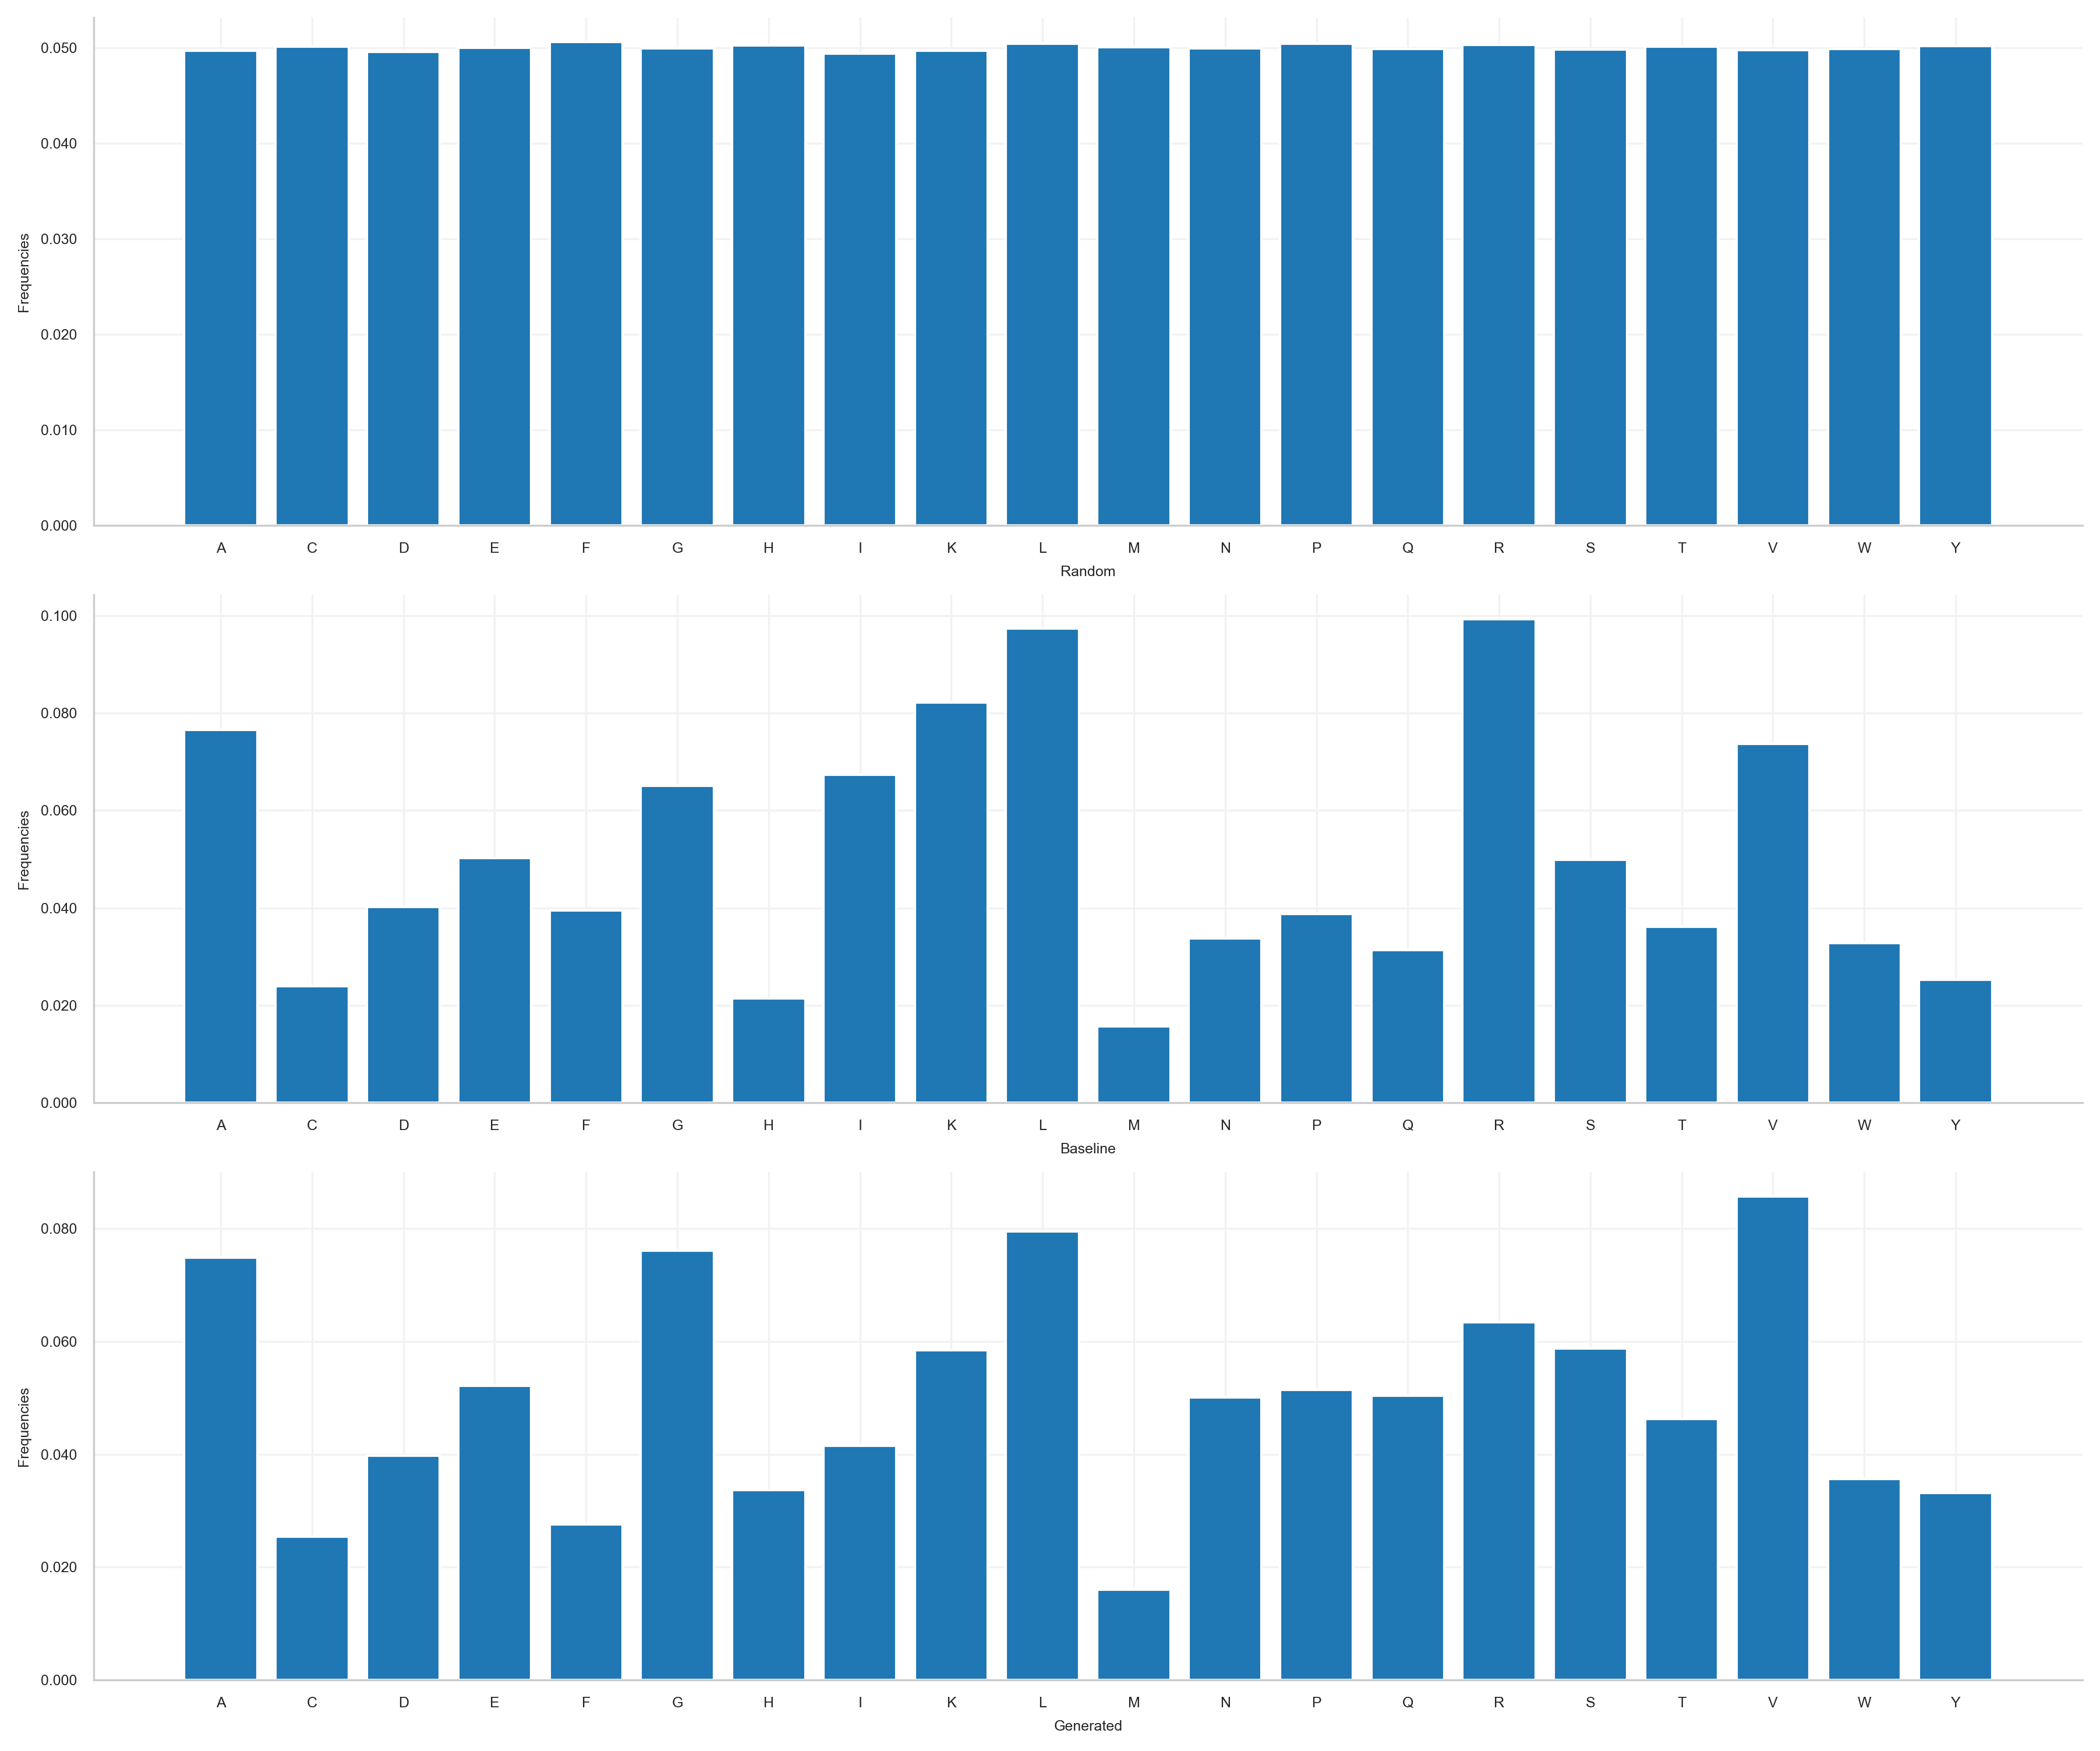

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(
    ncols=1, 
    nrows=3,
    figsize=(12, 10),
    dpi=300,
)

# Only use "Random" and "Generated"
selected_datasets = ['Random', 'Baseline', 'Generated']

for data, name, ax in zip([freq_random, freq_baseline, freq_generated],['Random', 'Baseline', 'Generated'], axes.flatten()):
    
    ax.bar(data.keys(), data.values())
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.set_xlabel(name)
    ax.set_ylabel('Frequencies')

# Adjust layout
plt.tight_layout()

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

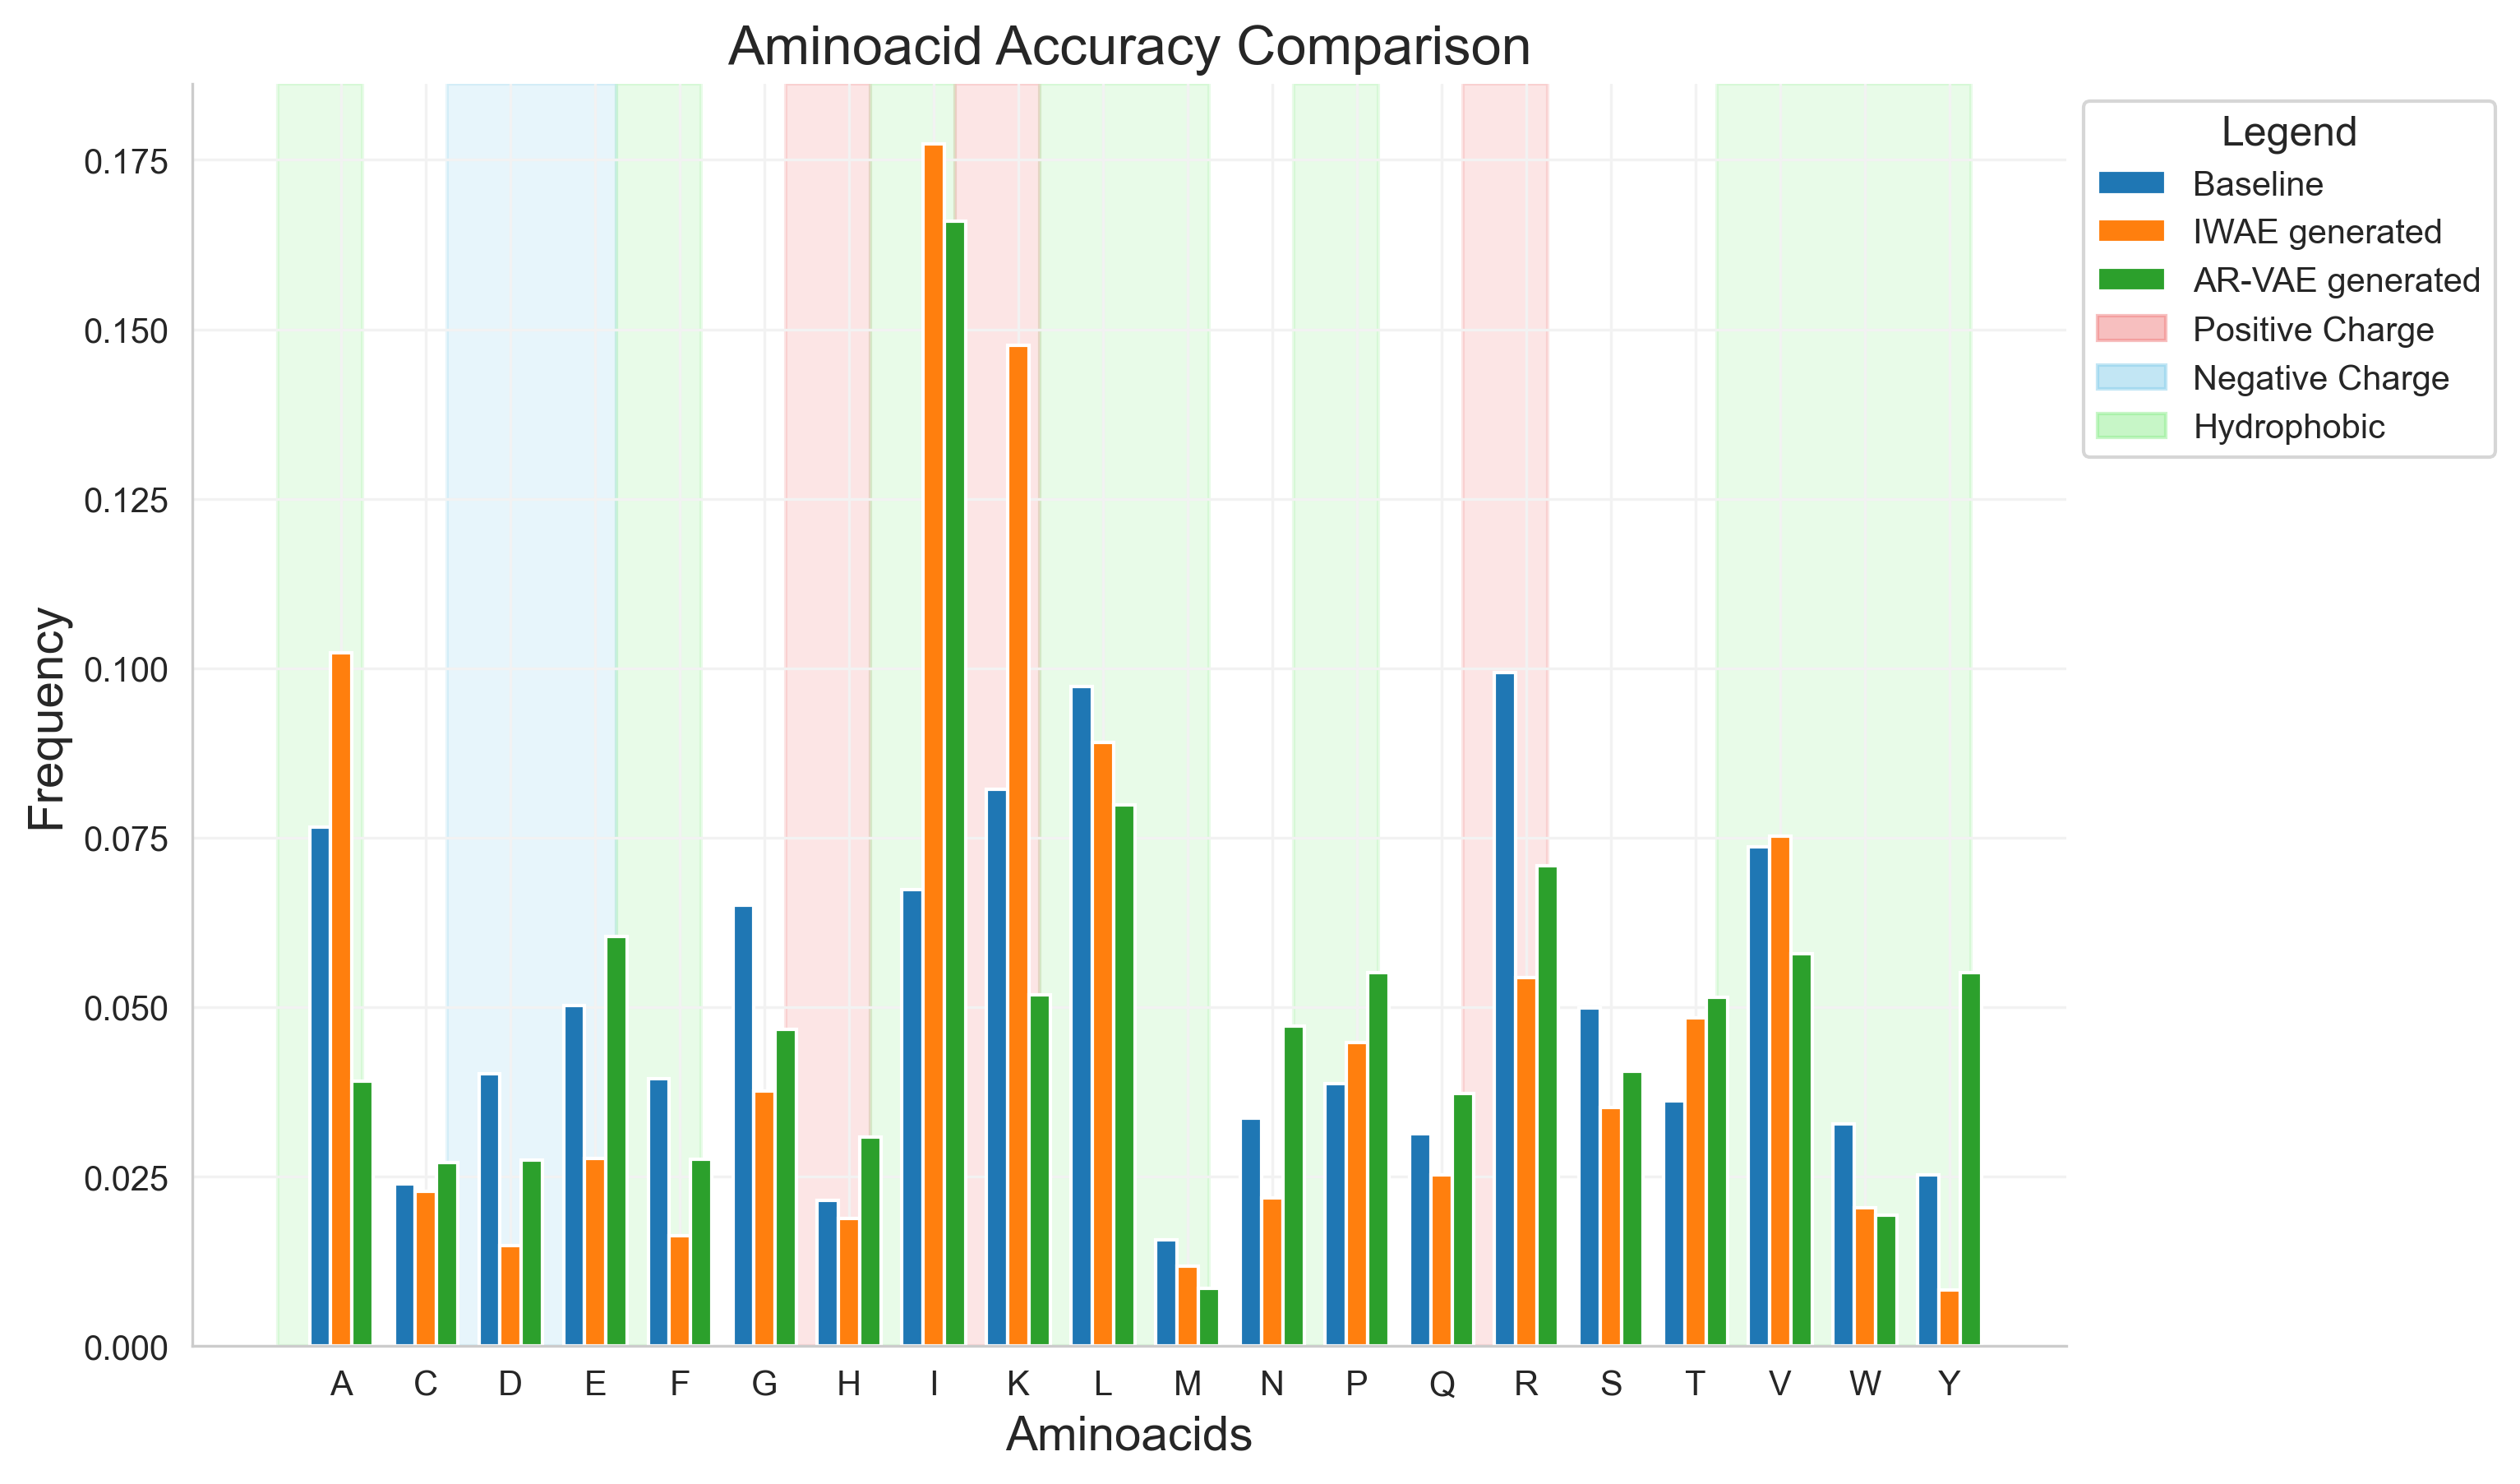

In [73]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches # Potrzebne do tworzenia niestandardowych elementów legendy

fig, ax = plt.subplots(
    ncols=1, 
    nrows=1,
    figsize=(12, 6),
    dpi=300,
)
all_possible_aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                    'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
datasets = [freq_baseline, freq_generated_iwae, freq_generated_arvae ]
all_keys = sorted(list(set(key for d in datasets for key in d.keys())))
selected_datasets = ['Baseline', 'IWAE generated', 'AR-VAE generated']
x = np.arange(len(all_keys))
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Matplotlib default colors: blue, orange, green
for i, (data, name) in enumerate(zip(datasets,selected_datasets)):
    values = [data.get(key, 0) for key in all_keys] # Użyj .get() na wypadek braku klucza
    ax.bar(x + i * 0.25, values, width=0.25, label=name, color=bar_colors[i])

ax.set_xticks(x + 0.25 * (len(datasets) - 1) / 2)
ax.set_xticklabels(all_keys)

aa_with_positive_charge = ['K', 'R', 'H']
aa_with_negative_charge = ['D', 'E']
aa_hydrophobic = ['A', 'V', 'F', 'P', 'I', 'L', 'M', 'W', 'Y'] # Upewnij się, że A, V, F, P, I, L, M są stringami

# Wybierz kolory dla grup - muszą być różne od bar_colors
group_colors = {
    'Positive Charge': 'lightcoral',  # Jasny koral
    'Negative Charge': 'skyblue',     # Błękit nieba
    'Hydrophobic': 'lightgreen'       # Jasna zieleń
}
aa_to_group = {}
for aa in all_possible_aas:
    if aa in aa_with_positive_charge:
        aa_to_group[aa] = 'Positive Charge'
    elif aa in aa_with_negative_charge:
        aa_to_group[aa] = 'Negative Charge'
    elif aa in aa_hydrophobic:
        aa_to_group[aa] = 'Hydrophobic'
idx_to_group_name = [aa_to_group.get(aa, 'None') for aa in all_keys] # 'None' dla AA bez przypisanej grupy

current_block_start_idx = 0
for idx in range(len(idx_to_group_name)):
    # Sprawdź, czy to koniec listy LUB czy grupa się zmienia
    if idx == len(idx_to_group_name) - 1 or idx_to_group_name[idx + 1] != idx_to_group_name[idx]:
        # To jest koniec bieżącego bloku
        end_idx_of_block = idx

        group_name = idx_to_group_name[current_block_start_idx]
        
        # Rysuj axvspan dla tego bloku
        if group_name in group_colors and group_name != 'Other/None': # Nie rysuj tła dla 'Other/None' jeśli nie chcesz
            color = group_colors[group_name]
            ax.axvspan(current_block_start_idx - 0.5, end_idx_of_block + 0.5,
                       color=color, alpha=0.2, zorder=0)
        
        # Ustaw początek następnego bloku
        current_block_start_idx = idx + 1



# --- Formatowanie osi Y ---
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('Aminoacids', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Aminoacid Accuracy Comparison', fontsize=16)

# Dodaj legendę, która pokaże, jaki kolor odpowiada którym danym
# Dodaj uchwyty dla kolorów grup
handles, labels = ax.get_legend_handles_labels()
group_legend_patches = []
for group_name, color in group_colors.items():
    group_legend_patches.append(mpatches.Patch(color=color, label=group_name, alpha=0.5)) # alpha zgodna z axvspan

# Połącz obie listy uchwytów
combined_handles = handles + group_legend_patches

ax.legend(
    handles=combined_handles,
    title="Legend",
    fontsize=10, # Zmniejsz, jeśli legenda jest zbyt duża
    title_fontsize=12,
    loc='upper left', # Zmień lokalizację, jeśli koliduje z grupami
    bbox_to_anchor=(1, 1) # Przesuń legendę poza wykres, jeśli jest za duża
)
ax.tick_params(axis='x', labelsize=10) # Obróć etykiety X dla czytelności
ax.tick_params(axis='y', labelsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Dostosuj rect, aby zrobić miejsce na legendę po prawej

# Save & Show Plot
# fig.savefig("./Filtered_Random_Uniprot.svg")
# fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

## AR-VAE